# Restricted Boltzmann Machine features for digit classification
_Example based on [sklearn documentation](http://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html) by Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve_

In this example, we will use a neural network to perform an unsupervised learning step before feeding the data into a logistic regression. We will see that this greatly improves our prediction accuracy.

For greyscale image data where pixel values can be interpreted as degrees of
blackness on a white background, like handwritten digit recognition, the
[Bernoulli Restricted Boltzmann machine model](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.BernoulliRBM.html#sklearn.neural_network.BernoulliRBM) can perform effective non-linear
feature extraction.

This example shows how to build a classification pipeline with a `BernoulliRBM`
feature extractor and a `LogisticRegression` classifier. The hyperparameters
of the entire model (learning rate, hidden layer size, regularization)
were optimized by grid search, but the search is not reproduced here because
of runtime constraints.

Logistic regression on raw pixel values is presented for comparison. The
example shows that the features extracted by the BernoulliRBM help improve the
classification accuracy.

In [1]:
import numpy as np
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.cross_validation import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

### Load data

In [37]:
digits = datasets.load_digits()

Let's plot the digits.

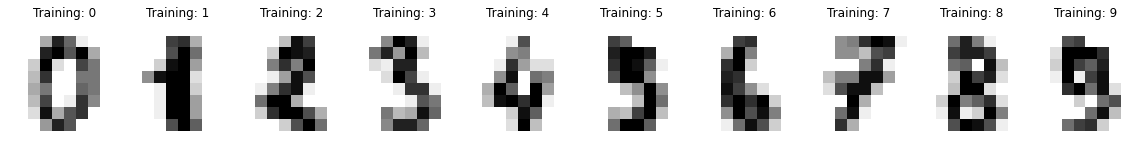

In [33]:
images_and_labels = list(zip(digits.images, digits.target))
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i\n' % label)

#### Data creation
In order to learn good latent representations from a small dataset, we
artificially generate more labeled data by perturbing the training data with
linear shifts of 1 pixel in each direction.

In [34]:
def nudge_dataset(X, y):
    """This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up."""
    direction_vectors = [
        [[0, 1, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [1, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 1], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 1, 0]]]

    shift = lambda x, w: convolve(
        x.reshape((8, 8)), mode='constant', weights=w).ravel()
    X = np.concatenate(
        [X] + [np.apply_along_axis(shift, 1, X, vector)
               for vector in direction_vectors])
    y = np.concatenate([y for _ in xrange(5)], axis=0)
    return X, y

In [35]:
X = np.asarray(digits.data, 'float32')
X, y = nudge_dataset(X, digits.target)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

#### Train models
The hyper-parameters were set by cross-validation, using a `GridSearchCV`. Here we are not performing cross-validation to save time. Note that more components (`rbm.n_components`) tend to give better prediction performance, but larger fitting time.

In [17]:
logistic = linear_model.LogisticRegression(C=6000.0)
rbm = BernoulliRBM(random_state=0, verbose=True, 
                   learning_rate=0.06, n_iter=20, n_components=100)
model = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

Training RBM-Logistic Pipeline.

In [18]:
%%time
model.fit(X_train, y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.39, time = 0.17s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.77, time = 0.22s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.94, time = 0.23s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.91, time = 0.26s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.69, time = 0.22s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.06, time = 0.22s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.89, time = 0.22s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.64, time = 0.24s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.36, time = 0.22s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.09, time = 0.24s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20.08, time = 0.22s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.82, time = 0.21s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19.64, time = 0.23s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -19.61, time = 0.22s
[BernoulliRBM] Iteration 15, 

Pipeline(steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=0.06, n_components=100, n_iter=20,
       random_state=0, verbose=True)), ('logistic', LogisticRegression(C=6000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0))])

Just a plain logistic regression.

In [19]:
%%time
logistic_classifier = linear_model.LogisticRegression(C=100.0)
logistic_classifier.fit(X_train, y_train)

CPU times: user 1.75 s, sys: 4.04 ms, total: 1.75 s
Wall time: 1.75 s


#### Evaluation

In [22]:
print 
print "Logistic regression using RBM features:\n%s\n" % \
    metrics.classification_report(
        y_test, model.predict(X_test))

print "Logistic regression using raw pixel features:\n%s\n" % \
    metrics.classification_report(
        y_test, logistic_classifier.predict(X_test))


Logistic regression using RBM features:
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       174
          1       0.92      0.95      0.93       184
          2       0.96      0.98      0.97       166
          3       0.97      0.92      0.94       194
          4       0.97      0.95      0.96       186
          5       0.93      0.93      0.93       181
          6       0.98      0.97      0.97       207
          7       0.95      1.00      0.97       154
          8       0.90      0.88      0.89       182
          9       0.91      0.93      0.92       169

avg / total       0.95      0.95      0.95      1797


Logistic regression using raw pixel features:
             precision    recall  f1-score   support

          0       0.85      0.94      0.89       174
          1       0.57      0.55      0.56       184
          2       0.72      0.85      0.78       166
          3       0.76      0.74      0.75       194
       

#### Plotting

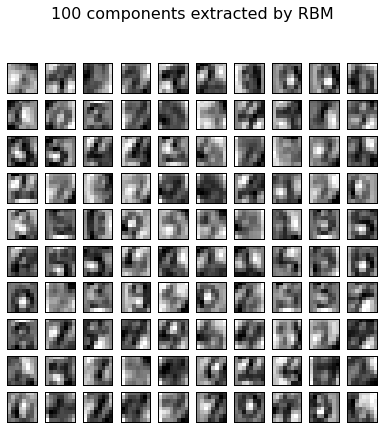

In [36]:
plt.figure(figsize=(6.2, 6))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

### References

1. [Neural Networks](http://scikit-learn.org/stable/modules/neural_networks.html) in `sklearn`
1. Hinton, G. E., Osindero, S. and Teh, Y. A fast learning algorithm for
deep belief nets. Neural Computation 18, pp 1527-1554. http://www.cs.toronto.edu/~hinton/absps/fastnc.pdf
1. Tieleman, T. Training Restricted Boltzmann Machines using
Approximations to the Likelihood Gradient. International Conference on Machine Learning (ICML) 2008